In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))
display(HTML("<style>pre { white-space: pre !important; }</style>"))

import matplotlib.pyplot as plt

plt.rcParams['figure.figsize'] = [8,6]

In [2]:
from pyspark import SparkConf, SparkContext
from pyspark.sql import SparkSession
from pyspark.sql import functions as F
from functools import reduce
from pyspark.sql import DataFrame

import graphframes as gf
import igraph as ig

import pandas as pd
import numpy as np

# Set up SparkContext
conf = SparkConf().setMaster('local')
#sc = SparkContext(conf = conf)

spark = SparkSession.builder.master("local[8]").appName("explore_email").getOrCreate()
spark.conf.set("spark.sql.execution.arrow.pyspark.enabled", "true")
sc = spark.sparkContext

In [3]:
PATH = "DATA/"
email = "email-Eu-core.txt"
dept_labels = "email-Eu-core-department-labels.txt"

# Exploration of Spark Graphframes on email exange data

found here : https://snap.stanford.edu/data/email-Eu-core.html

In [4]:
from pyspark.sql.types import StructType, StructField, IntegerType


schema_email = StructType([
    StructField("src", IntegerType(), True),
    StructField("dst", IntegerType(), True)])


dd_email = spark.read.format("csv").load(PATH + email,sep=' ',schema=schema_email)

In [5]:
dd_email.show(5)

+---+---+
|src|dst|
+---+---+
|  0|  1|
|  2|  3|
|  2|  4|
|  5|  6|
|  5|  7|
+---+---+
only showing top 5 rows



In [6]:
schema_labels = StructType([
    StructField("id", IntegerType(), True),
    StructField("department", IntegerType(), True)])


dd_labels = spark.read.format("csv").load(PATH + dept_labels,sep=' ',schema=schema_labels )

In [7]:
dd_labels.show(5)

+---+----------+
| id|department|
+---+----------+
|  0|         1|
|  1|         1|
|  2|        21|
|  3|        21|
|  4|        21|
+---+----------+
only showing top 5 rows



In [8]:
# Size of the dataFrames
print(dd_email.count())
print(dd_labels.count())

25571
1005


## Create the orignial Graph from the raw data

In [9]:
g = gf.GraphFrame(dd_labels, dd_email)
print(g)

GraphFrame(v:[id: int, department: int], e:[src: int, dst: int])


In [10]:
dd_labels.groupby('department').count().orderBy('count').show(45)

+----------+-----+
|department|count|
+----------+-----+
|        33|    1|
|        18|    1|
|        41|    2|
|        12|    3|
|        39|    3|
|        30|    4|
|        40|    4|
|        29|    5|
|        25|    6|
|        24|    6|
|        28|    8|
|        31|    8|
|        26|    9|
|        32|    9|
|        27|   10|
|         2|   10|
|         3|   12|
|        34|   13|
|        35|   13|
|        38|   13|
|        20|   14|
|        37|   15|
|         5|   18|
|         8|   19|
|        36|   22|
|        16|   25|
|        22|   25|
|        13|   26|
|        23|   27|
|         6|   28|
|        19|   29|
|        11|   29|
|         9|   32|
|        17|   35|
|        10|   39|
|         0|   49|
|         7|   51|
|        15|   55|
|        21|   61|
|         1|   65|
|        14|   92|
|         4|  109|
+----------+-----+



## Display a subgraph with igraph

In [11]:
#g2 = g.filterEdges("src == 160 or dst == 160")
#g2 = g.filterEdges("src == 107 or dst == 107")
g2 = g.filterVertices("department == 36")

In [12]:
ig_g2 = ig.Graph.TupleList(g2.edges.collect(), directed=True)

In [ ]:
#i = ig_g2.community_infomap()
#pal = ig.drawing.colors.ClusterColoringPalette(len(i))
#ig_g2.vs['color'] = pal.get_many(i.membership)
#ig.plot(ig_g2,bbox=(0, 0, 500, 500))

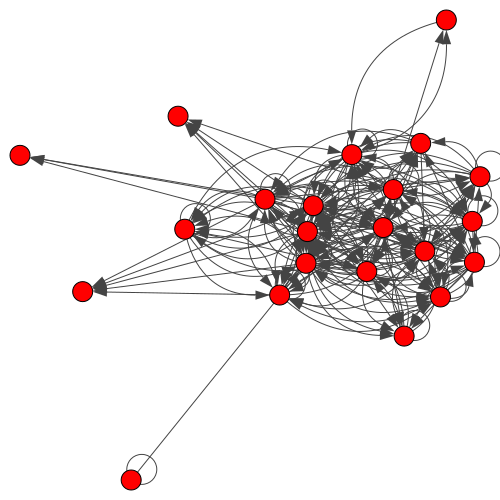

In [13]:
ig.plot(ig_g2,bbox=(0, 0, 500, 500))

## Let's try some algorithmic stuff

In [14]:
dd_size_dep = dd_labels.groupby('department').agg(F.count('id').alias('size_department'))

### Count degrees (in and out) and rank the vertices (the higher the degree, the better the rank. rank = 1 is the best)

In [15]:
g_degrees = (g.inDegrees.join(g.outDegrees,on='id',how='left')
                         .join(dd_labels,on='id',how='left')
                         .join(dd_size_dep,on='department',how='left')
            ) # if a vertex has no inDegree, it will not appear here...
g_degrees = g_degrees.withColumn('delta_degree',F.col('outDegree') - F.col('inDegree'))

In [16]:
g_degrees.createOrReplaceTempView('g_orig_degrees')

g_degrees2 = spark.sql("""

    select a.*, 
        rank() over(order by inDegree desc) as rank_in,
        rank() over(order by outDegree desc) as rank_out
    from g_orig_degrees as a

""")

In [17]:
g_degrees2.createOrReplaceTempView('g_degree')
g_degrees2.orderBy(F.col('outDegree').desc()).show()

+----------+---+--------+---------+---------------+------------+-------+--------+
|department| id|inDegree|outDegree|size_department|delta_degree|rank_in|rank_out|
+----------+---+--------+---------+---------------+------------+-------+--------+
|        36|160|     212|      334|             22|         122|      1|       1|
|        36| 82|     121|      227|             22|         106|     14|       2|
|        36|121|     157|      222|             22|          65|      4|       3|
|        36|107|     169|      204|             22|          35|      3|       4|
|        36| 86|     154|      202|             22|          48|      5|       5|
|        36| 62|     179|      190|             22|          11|      2|       6|
|        26| 13|      61|      172|              9|         111|     97|       7|
|        14|249|     112|      160|             92|          48|     20|       8|
|         4|183|     143|      159|            109|          16|      7|       9|
|        34|434|

### Get the pageRank of all vertices and rank them

In [18]:
%%time
g_pageRank = g.pageRank(resetProbability=0.15, tol=0.01)

Wall time: 9.21 s


In [19]:
g_pageRank.vertices.createOrReplaceTempView('g_orig_pagerank')

g_pageRank_vertices = spark.sql("""

    select a.*, rank() over(order by pagerank desc) as rank_pagerank
    from g_orig_pagerank as a

""")

g_pageRank_vertices.orderBy(F.col('pagerank').desc()).show(5)

+---+----------+-----------------+-------------+
| id|department|         pagerank|rank_pagerank|
+---+----------+-----------------+-------------+
|  1|         1|9.804263268719154|            1|
|130|         0|7.227570769241558|            2|
|160|        36| 6.59564256149081|            3|
| 62|        36|5.199671693431897|            4|
| 86|        36|5.029290715352041|            5|
+---+----------+-----------------+-------------+
only showing top 5 rows



### Get the number of triangle passing through every vertices and rank them

In [20]:
g_triangle = g.triangleCount()

In [21]:
g_triangle.createOrReplaceTempView("g_orig_triangle")
g_triangle = spark.sql("""

    select id, department, count as count_triangles, rank() over(order by count desc) as rank_triangles
    from g_orig_triangle

""")
g_triangle.orderBy(F.col('count').desc()).show(5)

+---+----------+---------------+--------------+
| id|department|count_triangles|rank_triangles|
+---+----------+---------------+--------------+
|160|        36|           5549|             1|
|121|        36|           4633|             2|
| 82|        36|           4412|             3|
|107|        36|           4059|             4|
|249|        14|           3490|             5|
+---+----------+---------------+--------------+
only showing top 5 rows



### Put everything together : inDegree, outDegree, pageRank and triangles along with respective ranks.

Create a dummy ranking which is simply the average of all ranks. Not a proper rank per se.

In [22]:
g_metrics = g_degrees2.join(g_pageRank_vertices.select('id','pagerank','rank_pagerank'),on='id').join(g_triangle.select('id','count_triangles','rank_triangles'),on='id')
g_metrics = g_metrics.withColumn('rank_all_weight',(g_metrics.rank_in + g_metrics.rank_out + g_metrics.rank_pagerank + g_metrics.rank_triangles)/4)

In [23]:
# select a few interesting candidates
g_metrics.filter('rank_pagerank == 1 or rank_all_weight <= 5').show()

+---+----------+--------+---------+---------------+------------+-------+--------+-----------------+-------------+---------------+--------------+---------------+
| id|department|inDegree|outDegree|size_department|delta_degree|rank_in|rank_out|         pagerank|rank_pagerank|count_triangles|rank_triangles|rank_all_weight|
+---+----------+--------+---------+---------------+------------+-------+--------+-----------------+-------------+---------------+--------------+---------------+
|160|        36|     212|      334|             22|         122|      1|       1| 6.59564256149081|            3|           5549|             1|            1.5|
|121|        36|     157|      222|             22|          65|      4|       3|4.637096480718998|            8|           4633|             2|           4.25|
|107|        36|     169|      204|             22|          35|      3|       4|4.912693762619514|            6|           4059|             4|           4.25|
| 62|        36|     179|      190

## Graphframes motifs exploration

### start with vertex id=160

In [24]:
#from 160 and returning vs from 160 and not returning
motifs_from_160 = g.find("(a)-[e]->(b)")
all_160 = motifs_from_160.filter("a.id == 160").count()

motifs_no_return_160 = g.find("(a)-[e]->(b); !(b)-[]->(a)")
not_return_160 = motifs_no_return_160.filter("a.id == 160").count()

In [25]:
print(all_160, not_return_160)

334 134


so from the 334 of outbound relation of id=160, 134 of them are unidirectionnal. Who are these 134 ??

In [26]:
id_no_return_160 = motifs_no_return_160.filter("a.id == 160").select("b.id")
id_no_return_160_degree = id_no_return_160.join(g_degrees2,on=id_no_return_160.id == g_degrees.id)

In [28]:
id_no_return_160_degree.orderBy(F.col('outDegree').desc()).show(5)

+---+----------+---+--------+---------+---------------+------------+-------+--------+
| id|department| id|inDegree|outDegree|size_department|delta_degree|rank_in|rank_out|
+---+----------+---+--------+---------+---------------+------------+-------+--------+
|107|        36|107|     169|      204|             22|          35|      3|       4|
|533|        35|533|      85|      123|             13|          38|     48|      21|
|303|        20|303|      83|       87|             14|           4|     50|      54|
| 65|         4| 65|      40|       84|            109|          44|    208|      56|
|232|         4|232|      77|       79|            109|           2|     54|      64|
+---+----------+---+--------+---------+---------------+------------+-------+--------+
only showing top 5 rows



It is interesting that ID=107 receives emails from ID=160 but do not communicate with it but ranks 3rd in and 4th out. The other candidates look rather down in both the ranking.

In [29]:
# From 160, but no return and to a second degree of separation to reach vertice id = 2
motifs = g.find("(a)-[e]->(b); !(b)-[]->(a); (b)-[e2]->(c)")
motifs.filter("a.id == 160 and c.id == 2").show()

+---------+----------+---------+--------+-------+
|        a|         e|        b|      e2|      c|
+---------+----------+---------+--------+-------+
|{160, 36}|{160, 832}|{832, 21}|{832, 2}|{2, 21}|
|{160, 36}|{160, 286}|{286, 21}|{286, 2}|{2, 21}|
|{160, 36}| {160, 54}| {54, 22}| {54, 2}|{2, 21}|
|{160, 36}| {160, 89}| {89, 20}| {89, 2}|{2, 21}|
|{160, 36}|  {160, 3}|  {3, 21}|  {3, 2}|{2, 21}|
|{160, 36}|{160, 107}|{107, 36}|{107, 2}|{2, 21}|
|{160, 36}|{160, 826}|{826, 21}|{826, 2}|{2, 21}|
|{160, 36}|{160, 194}|{194, 21}|{194, 2}|{2, 21}|
|{160, 36}|{160, 162}|{162, 37}|{162, 2}|{2, 21}|
|{160, 36}| {160, 56}| {56, 21}| {56, 2}|{2, 21}|
|{160, 36}|{160, 158}|{158, 19}|{158, 2}|{2, 21}|
+---------+----------+---------+--------+-------+



It appears that ID=160 and ID=107 are highly connected people, from the same department=36, but the edge between both is asymetric, from 160 -- > 107.

Let's explore more the department=36

In [30]:
# department| id|inDegree|outDegree|size_department|delta_degree|rank_in|rank_out
dd_degrees_dep = spark.sql("""

    select department, mean(inDegree) as m_in, stddev(inDegree) as s_in, skewness(inDegree) as skewness_in,
            mean(outDegree) as m_out, stddev(outDegree) as s_out, skewness(outDegree) as skewness_out,
            max(size_department) as size_department,
            min(rank_in) as min_rank_in,
            min(rank_out) as min_rank_out
    from g_degree
    group by department

""")

In [31]:
dd_degrees_dep.orderBy(F.col('min_rank_out')).show()

+----------+------------------+------------------+--------------------+------------------+------------------+-------------------+---------------+-----------+------------+
|department|              m_in|              s_in|         skewness_in|             m_out|             s_out|       skewness_out|size_department|min_rank_in|min_rank_out|
+----------+------------------+------------------+--------------------+------------------+------------------+-------------------+---------------+-----------+------------+
|        36|  86.5909090909091|  63.1797579781833|  0.2633676902245973|122.84210526315789| 88.62672230446498| 0.5643319377240537|             22|          1|           1|
|        26|40.888888888888886| 44.39156576548197|  0.8756202537078251|              63.5| 59.10523302913686| 0.6320101699611682|              9|         18|           7|
|        14|24.706521739130434|21.073152569023083|  1.6927116739093357|25.925925925925927| 24.37559116092253| 2.5696169552352877|             92|

In [32]:
g_degrees2.filter('department == 36').orderBy('rank_out').show(25)

+----------+---+--------+---------+---------------+------------+-------+--------+
|department| id|inDegree|outDegree|size_department|delta_degree|rank_in|rank_out|
+----------+---+--------+---------+---------------+------------+-------+--------+
|        36|160|     212|      334|             22|         122|      1|       1|
|        36| 82|     121|      227|             22|         106|     14|       2|
|        36|121|     157|      222|             22|          65|      4|       3|
|        36|107|     169|      204|             22|          35|      3|       4|
|        36| 86|     154|      202|             22|          48|      5|       5|
|        36| 62|     179|      190|             22|          11|      2|       6|
|        36|166|     127|      125|             22|          -2|     12|      18|
|        36|142|      99|      120|             22|          21|     31|      22|
|        36| 83|      86|      119|             22|          33|     46|      24|
|        36|283|

In [33]:
g_36 = g.filterVertices("department == 36")
lp_36 = g_36.labelPropagation(maxIter=50)
lp_36.select("id", "label").show(25)

+---+-----+
| id|label|
+---+-----+
|160|   83|
|373|   83|
|752|   83|
| 82|   83|
|366|   83|
|283|   83|
|950|   83|
|107|   83|
|121|   83|
|166|   83|
|142|   83|
|601|   83|
| 62|   83|
|594|   83|
| 83|   83|
| 86|   83|
| 49|   49|
|372|   83|
|282|   83|
|693|   83|
|494|   83|
|932|   83|
+---+-----+



Label propagation within the department=36 did not give much interesting information. 

### Let's use motifs to explore our top pargeRank ranker vertex id=1

In [34]:
motifs_1 = g.find("(a)-[e]->(b);(b)-[e2]->(c)")

# This is tricky... We have 2 degrees of separation. The end of the string should reach vertex id=1 but comes from department=36
in_1 = motifs_1.filter("c.id == 1 and b.department == 36")

details_in_1 = in_1.join(g_metrics.alias('gm'),on= in_1.a.id == g_metrics.id).select('gm.*').dropDuplicates()

In [36]:
details_in_1.orderBy('rank_all_weight').show(5)

+---+----------+--------+---------+---------------+------------+-------+--------+-----------------+-------------+---------------+--------------+---------------+
| id|department|inDegree|outDegree|size_department|delta_degree|rank_in|rank_out|         pagerank|rank_pagerank|count_triangles|rank_triangles|rank_all_weight|
+---+----------+--------+---------+---------------+------------+-------+--------+-----------------+-------------+---------------+--------------+---------------+
|160|        36|     212|      334|             22|         122|      1|       1| 6.59564256149081|            3|           5549|             1|            1.5|
|121|        36|     157|      222|             22|          65|      4|       3|4.637096480718998|            8|           4633|             2|           4.25|
|107|        36|     169|      204|             22|          35|      3|       4|4.912693762619514|            6|           4059|             4|           4.25|
| 62|        36|     179|      190

In [37]:
in_1.show(5)

+---------+----------+---------+--------+------+
|        a|         e|        b|      e2|     c|
+---------+----------+---------+--------+------+
| {82, 36}| {82, 121}|{121, 36}|{121, 1}|{1, 1}|
|{141, 14}|{141, 142}|{142, 36}|{142, 1}|{1, 1}|
| {83, 36}|  {83, 82}| {82, 36}| {82, 1}|{1, 1}|
|{252, 20}|{252, 121}|{121, 36}|{121, 1}|{1, 1}|
|{282, 36}|{282, 121}|{121, 36}|{121, 1}|{1, 1}|
+---------+----------+---------+--------+------+
only showing top 5 rows



In [39]:
edges_1 = in_1.select("e.src", "e.dst").dropDuplicates().union(in_1.select("e2.src","e2.dst").dropDuplicates())

# Construct the subgraph
g_motifs_1 = gf.GraphFrame(g.vertices, edges_1).dropIsolatedVertices()

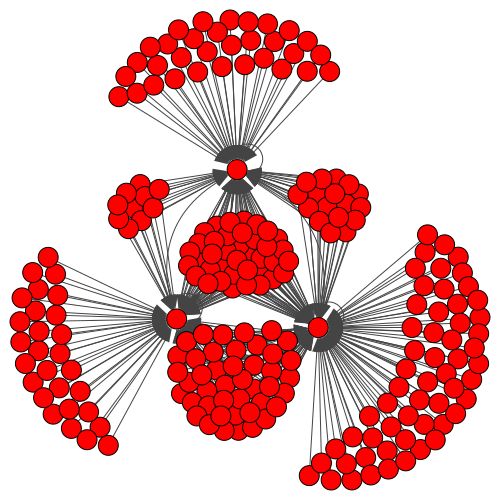

In [40]:
ig_motifs_1 = ig.Graph.TupleList(g_motifs_1.edges.collect(), directed=True)
ig.plot(ig_motifs_1,bbox=(0, 0, 500, 500))

## Connected Components

There seems to be a handfull of vertices not connected to the network

In [46]:
sc.setCheckpointDir(PATH)
connected_comp = g.connectedComponents()

In [47]:
connected_comp.groupby('component').count().orderBy(F.col('count').desc()).show()

+---------+-----+
|component|count|
+---------+-----+
|        0|  986|
|      691|    1|
|      744|    1|
|      703|    1|
|      580|    1|
|      675|    1|
|      746|    1|
|      731|    1|
|      648|    1|
|      653|    1|
|      658|    1|
|      772|    1|
|      711|    1|
|      732|    1|
|      684|    1|
|      670|    1|
|      660|    1|
|      798|    1|
|      633|    1|
|      808|    1|
+---------+-----+



### Do we have any loose edges ? (there shouldn't be)

In [41]:
# Original Graph size in edges and vertices
g.edges.count(), g.vertices.count()

(25571, 1005)

In [42]:
# if we drop Isolated Vertices ?
g_drop = g.dropIsolatedVertices()

In [43]:
g_drop.edges.count(), g_drop.vertices.count()

# nope

(25571, 1005)

### Do we have people who sends to themselves ? How are they otherwise ?

In [44]:
g_same = g.filterEdges("src == dst").dropIsolatedVertices()

In [45]:
g_same.edges.count(), g_same.vertices.count()

(642, 642)

They do represent almost 64% of the population, which is much...